
<center><h1>                        DSCI 552 FINAL PROJECT   </h1></center>
<br>
<center><font size="5"> Name : Sneha Chawan</font></center>
<center><font size="5"> USC ID: 8611548513 </font></center>
<center><font size="5"> Github: sneha-chawan</font></center>


<center><h1>  VGG16 Model</h1></center>

### NOTE : I have done my project on colab and since colab has runtime disconnection issue, I have made 4 different notebooks, one for every model.

### This notebook contains code for augmentation, preprocessing and VGG16 model

### 1) Loading Data

In [1]:
!wget -O '/content/data.zip' 'https://www.dropbox.com/sh/38zygdpo6u7alwy/AABCsKz3qLFs1lykelJ9ookJa/data.zip?dl=0'


--2023-12-09 21:42:22--  https://www.dropbox.com/sh/38zygdpo6u7alwy/AABCsKz3qLFs1lykelJ9ookJa/data.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.13.18, 2620:100:6022:18::a27d:4212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.13.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /sh/raw/38zygdpo6u7alwy/AABCsKz3qLFs1lykelJ9ookJa/data.zip [following]
--2023-12-09 21:42:22--  https://www.dropbox.com/sh/raw/38zygdpo6u7alwy/AABCsKz3qLFs1lykelJ9ookJa/data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc458fc0199af3bb61e27919089e.dl.dropboxusercontent.com/cd/0/inline/CJFpve9uPfF9K7vfqhPetNGDNtx4NU2UGnrnoe9RMmtboz96oD8SDjVFYP_RAh0-ou1sIJjkR8y9W_GC7gNRhN-vz67UmyCg3oELcW63pg-T_pZrcfRFj0cTQ-ZUgyRafyg/file# [following]
--2023-12-09 21:42:22--  https://uc458fc0199af3bb61e27919089e.dl.dropboxusercontent.com/cd/0/inline/CJFpve9uPfF9K7vfqhPetNGDNtx4NU2UGnrnoe9RMmtboz

In [2]:

!unzip /content/data.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/ESP_032207_1350_5120_10240_0_5120/labels/background/ESP_032207_1350_5120_5419_4485_4784.json  
  inflating: __MACOSX/data/ESP_032207_1350_5120_10240_0_5120/labels/background/._ESP_032207_1350_5120_5419_4485_4784.json  
  inflating: data/ESP_032207_1350_5120_10240_0_5120/labels/background/ESP_032207_1350_5419_5718_1196_1495.json  
  inflating: __MACOSX/data/ESP_032207_1350_5120_10240_0_5120/labels/background/._ESP_032207_1350_5419_5718_1196_1495.json  
  inflating: data/ESP_032207_1350_5120_10240_0_5120/labels/background/ESP_032207_1350_5718_6017_4784_5083.json  
  inflating: __MACOSX/data/ESP_032207_1350_5120_10240_0_5120/labels/background/._ESP_032207_1350_5718_6017_4784_5083.json  
  inflating: data/ESP_032207_1350_5120_10240_0_5120/labels/background/ESP_032207_1350_6914_7213_4186_4485.json  
  inflating: __MACOSX/data/ESP_032207_1350_5120_10240_0_5120/labels/background/._ESP_032207_1350_6914_7213_4186_4485.json  
 

### 2) Image Augmenattion

In [3]:
import os
import random
from PIL import Image

# Function to perform rotating or zooming on images
def transform_image(image_path):
    img = Image.open(image_path)
    # Rotate the image by a random angle between -45 and 45 degrees
    angle = random.randint(-45, 45)
    rotated_img = img.rotate(angle, expand=True)
    # Resize the image to 299x299
    resized_img = rotated_img.resize((299, 299))
    # Save the transformed image with "_aug" appended to the original filename
    save_path = os.path.join(os.path.dirname(image_path), f"{os.path.splitext(os.path.basename(image_path))[0]}_aug.png")
    resized_img.save(save_path)

# Path to the folder containing images
data_path = '/content/data'

# Read train_source_images.txt
with open('train_source_images.txt', 'r') as file:
    folder_names = file.read().splitlines()

# Loop through each folder name in train_source_images.txt
for folder_name in folder_names:
    # Split the folder name using '_'
    items = folder_name.split('_')

    # Get the list of folders inside the data_path directory
    data_folders = os.listdir(data_path)

    # Loop through each folder in the data_path directory
    for data_folder in data_folders:
        data_folder_items = data_folder.split('_')

        # Compare first 3 items
        if items[:3] == data_folder_items[:3]:
            # Define paths for background and frost folders
            background_path = os.path.join(data_path, data_folder, 'tiles', 'background')
            frost_path = os.path.join(data_path, data_folder, 'tiles', 'frost')

            # Loop through files in background and frost folders
            for path in [background_path, frost_path]:
                if os.path.exists(path):
                    # Get the list of files in the background/frost path
                    files = os.listdir(path)
                    for file_name in files:
                        # Perform rotating or zooming on the image and save the transformed image
                        transform_image(os.path.join(path, file_name))


### 3) Data preprocessing

In [4]:
import os
import os.path as op
import json
from pathlib import Path
import shutil
import logging
import numpy as np
from tqdm import tqdm
from skimage import io


In [5]:
# Logging configuration
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size)
SEED = 17

# Head directory containing all image subframes. Update with the relative path of your data directory
data_head_dir = Path('/content/data')

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]

In [6]:
# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

# Load the subframe names for the three data subsets
train_ids = load_text_ids('./train_source_images.txt')
validate_ids = load_text_ids('./val_source_images.txt')
test_ids = load_text_ids('./test_source_images.txt')

# Generate a list containing the dataset split for the matching subdirectory names
subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif(src_id in test_ids):
        subdir_splits.append('test')
    else:
        logging.warning(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)

In [7]:
import random
import tensorflow as tf
from PIL import Image


def load_and_preprocess(img_loc, label):
  def _inner_function(img_loc, label):
    # Convert tensor to native type
    img_loc_str = img_loc.numpy().decode('utf-8')
    # Load image using PIL and convert to RGB
    img = Image.open(img_loc_str).convert('RGB')
    # Convert PIL image to numpy array
    img = np.array(img)
    img = tf.image.resize(img, [299, 299])
    # Normalize the image to the [0, 1] range
    img = img / 255.0
    # Convert label to integer (assuming binary classification)
    label = 1 if label.numpy().decode('utf-8') == 'frost' else 0
    return img, label

  # Wrap the Python function
  X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])

  # Set the shape of the tensors
  X.set_shape([299, 299, 3])
  y.set_shape([]) # Scalar label

  return X, y

def load_subdir_data(dir_path, image_size, seed=None):

    """Helper to create a TF dataset from each image subdirectory"""

    # Grab only the classes that (1) we want to keep and (2) exist in this directory
    tile_dir = dir_path / Path('tiles')
    label_dir = dir_path /Path('labels')

    loc_list = []

    for folder in os.listdir(tile_dir):
        if os.path.isdir(os.path.join(tile_dir, folder)):
            for file in os.listdir(os.path.join(tile_dir, folder)):
                if file.endswith(".png"):
                    loc_list.append((os.path.join(os.path.join(tile_dir, folder), file), folder))

    return loc_list

# Loop over all subframes, loading each into a list
tf_data_train, tf_data_test, tf_data_val = [], [], []
tf_dataset_train, tf_dataset_test, tf_dataset_val = [], [], []

# Update the batch and buffer size as per your model requirements
buffer_size = 64
batch_size = 32

for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split=='validate':
        tf_data_val.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='train':
        tf_data_train.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='test':
        tf_data_test.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))

random.shuffle(tf_data_train)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_train = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_train = tf_dataset_train.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train = tf_dataset_train.shuffle(buffer_size=buffer_size).batch(batch_size)

random.shuffle(tf_data_val)
img_list, label_list = zip(*tf_data_val)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_val = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_val = tf_dataset_val.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=buffer_size).batch(batch_size)

random.shuffle(tf_data_test)
img_list, label_list = zip(*tf_data_test)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_test = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_test = tf_dataset_test.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test = tf_dataset_test.shuffle(buffer_size=buffer_size).batch(batch_size)

### 4) Training VGG16 with last layer

58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/15
1855/1855 [==============================] - 897s 475ms/step - loss: 0.2862 - accuracy: 0.8770 - val_loss: 0.9509 - val_accuracy: 0.7134
Epoch 2/15
1855/1855 [==============================] - 864s 466ms/step - loss: 0.2149 - accuracy: 0.9114 - val_loss: 0.7277 - val_accuracy: 0.7627
Epoch 3/15
1855/1855 [==============================] - 860s 464ms/step - loss: 0.1936 - accuracy: 0.9214 - val_loss: 0.7082 - val_accuracy: 0.7904
Epoch 4/15
1855/1855 [==============================] - 859s 463ms/step - loss: 0.1775 - accuracy: 0.9279 - val_loss: 0.5316 - val_accuracy: 0.8300
Epoch 5/15
1855/1855 [==============================] - 856s 461ms/step - loss: 0.1653 - accuracy: 0.9335 - val_loss: 0.5071 - val_accuracy: 0.8321
Epoch 6/15
1855/1855 [==============================] - 859s 463ms/step - loss: 0.1565 - accuracy: 0.9382 - val_loss: 0.4370 - val_accuracy: 0.8496
Epoch 7/15
1855/1855 [=========================

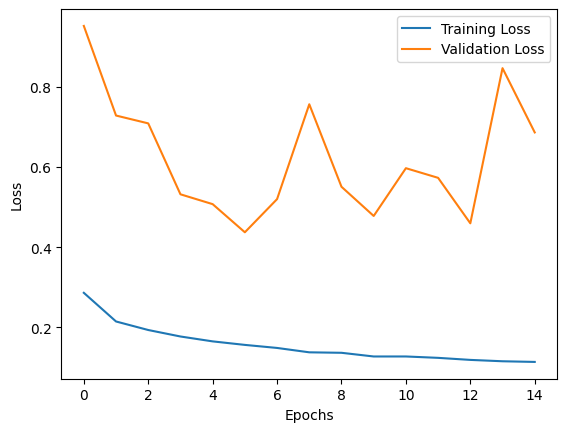

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16


base_model = VGG16(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze all layers in the base model
base_model.trainable = False
NUM_CLASSES =2

inputs = tf.keras.Input(shape=(299, 299, 3))
x = base_model(inputs, training=False)  # Use the base model as a layer
x = Flatten()(x)  # Flatten the output of VGG16
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)  

model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer=Adam(),
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=10 , restore_best_weights=True)

# Train the model
history = model.fit(tf_dataset_train,
                    epochs=15,  # Train for at least 20 epochs
                    validation_data=tf_dataset_val,
                    callbacks=[early_stopping],
                    batch_size=8)  # Use batch size of 8

# Plot training and validation errors vs. epochs
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


### 5) Classification report

In [9]:
from sklearn.metrics import classification_report

y_pred = []
y_true = []

for img, label in tf_dataset_test:
    pred = model.predict(img)
    y_pred.extend(tf.argmax(pred, axis=1).numpy())
    y_true.extend(label.numpy())

# Generate classification report
report = classification_report(y_true, y_pred)
print(report)


1/1 [==============================] - 4s 4s/step
              precision    recall  f1-score   support

           0       0.86      0.97      0.91      4418
           1       0.99      0.91      0.95      8405

    accuracy                           0.93     12823
   macro avg       0.92      0.94      0.93     12823
weighted avg       0.94      0.93      0.94     12823



### The accuracy as seen above is 93%

### d) vi) Compare the results of transfer learning with those of CNN + MLP model and explain them

The VGG16 model performs the best among the three models based on the provided metrics. It seems to have better discriminative capabilities, yielding higher precision, recall, and F1-scores for both classes compared to the other models. This could be attributed to VGG16's deeper architecture and its ability to capture more complex features from the images.

The CNN model also performs well but slightly less than VGG16, while the ResNet and EfficientNetBO models exhibits comparatively lower performance metrics, indicating it might struggle to capture certain intricate patterns within the data.

Therefore, based on the provided metrics, the VGG16 model appears to be the best-performing model for this specific classification task among the three models considered.